In [10]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 

# Transfer Learning

## Transfer Learning for Neural Network

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

> Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.


1. Take the weights and architecture of a [pre-trained network](https://keras.io/api/applications/)
2. Load the "convolutional base" of the model (everything except the final dense layers)
3. Freeze all the layers of the base (weights become fixed)
4. Add a fully connected dense layer on top
5. Add a task specific dense output layer
6. Compile and fit the model to your data

### Getting image data into keras
Keras has its own in build Objects and Methods to get image data in efficiently
See: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image

- `class ImageDataGenerator`: Generate batches of tensor image data with real-time data augmentation

In [11]:
# this are the folder names of the things you want to classify
classes = ['phone', 'wallet']
# plug in the path to your data folder
base_path = '../data'

In [12]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
    # fill_mode='nearest',
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2    
)

In [13]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=135,
        target_size=(224, 224)
)

Found 155 images belonging to 2 classes.


In [14]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((135, 224, 224, 3), (135, 2))

#### (Advanced: Data augmentation)

> https://keras.io/guides/transfer_learning/

Applies random distortions and transformations to the images (only on your training data!). You need to store your training and validation data at separate locations and use a second `ImageDataGenerator` for your validation data. 

### Select the convolutional base and freeze the weights

In [13]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

# freeze it!
base_model.trainable = False

### Add your own dense layers on top

In [14]:
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation='softmax'))
model.add(keras.layers.BatchNormalization())
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Functi (None, 1280)              410208    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               128100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2)                 8         
Total params: 538,518
Trainable params: 128,306
Non-trainable params: 410,212
_________________________________________________________________


### Compile and train!

In [15]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          batch_size=len(xtrain), 
          callbacks=[callback],
          # use 30% of the data for validation
          validation_split=0.3)

Epoch 1/50
1/1 - 5s - loss: 7.8876 - categorical_accuracy: 0.4894 - val_loss: 0.7713 - val_categorical_accuracy: 0.6098
Epoch 2/50
1/1 - 1s - loss: 7.8876 - categorical_accuracy: 0.5106 - val_loss: 0.7733 - val_categorical_accuracy: 0.6098
Epoch 3/50
1/1 - 1s - loss: 9.2593 - categorical_accuracy: 0.4255 - val_loss: 0.7750 - val_categorical_accuracy: 0.6098
Epoch 4/50
1/1 - 1s - loss: 7.0302 - categorical_accuracy: 0.4787 - val_loss: nan - val_categorical_accuracy: 0.3902


### (Use it to predict)

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
img = image.load_img('phone_paula.png')

In [ ]:
plt.imshow(img)

In [ ]:
img.size

In [ ]:
a = image.img_to_array(img)

In [ ]:
a = np.expand_dims(a, axis = 0)

In [ ]:
a.shape

In [ ]:
model.predict(a)

In [ ]:
model.predict(a)[0].round(decimals = 3)

In [ ]:
classes

In [ ]:
plt.bar(x = classes, height = model.predict(a)[0])

### Save your model for later

In [16]:
model.save('models/wallet_phone.h5')

---
### (Advanced Optional Step: Fine Tuning)

This is done after the initial training! Adapt a few of the base layers to the specific learning task by retraining the model. This can improve accuracy, especially if the original learning task of the pre-trained model differs a lot from the actual task.

1. Unfreeze some (or all) of the layers in the convolutional base (starting with the base output layer)
2. Recompile your model and choose a very low learning rate (`1e-5`)
2. Continue training the model but stop early to avoid overfitting

## How to continue!

- Load the trained model into `predict.py` (the modified `capture.py` with the `predict_frame(frame)` function) 

- If you don't have it yet, write a fuction `predict_frame(frame)` that uses the trained model to predict the object in the current frame. It should return a dictionary of class probabilities and names.
    - make sure that the input image to the model is of size (224, 224)
- Modify the script such that it makes a prediction once you press the `p` key
- Write the prediction as a log message to the terminal

### Advanced

- Display the result of the prediction on the current webcam frame
- Make an automatic prediction every second (Hint: the `while` loop has a speed of approx. 30 frames per second)

In [49]:
#model = keras.models.load_model('models/wallet_phone.h5')

In [16]:
#pip uninstall keras-utils

In [2]:
model = keras.models.load_model('models/wallet_phone.h5')

In [3]:
from tensorflow.keras.utils import plot_model

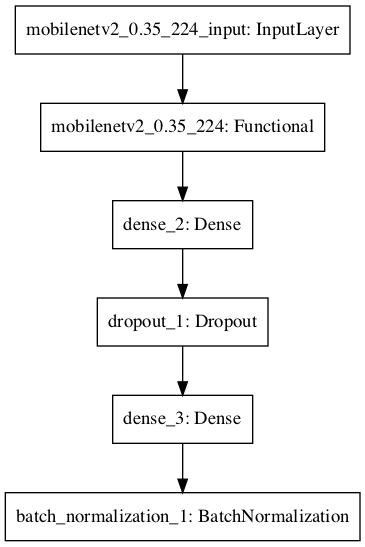

In [4]:
plot_model(model, to_file='model.png')

In [1]:
#pip uninstall graphviz

In [1]:
#pip uninstall pydotplus

In [54]:
def predict_frame(img, model_test):

    img = image.img_to_array(img, dtype = 'uint8') 

# reverse color channels
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#reshape input
    img = np.expand_dims(img, axis = 0)

    classes = ['phone','wallet']

    
    
    model_test = keras.models.load_model('models/wallet_phone.h5')

    pred = model_test.predict(img)
    

    print(pred)

In [51]:
from tensorflow.keras.preprocessing import image

In [56]:
img = image.load_img('phone_paula.png')
model_test = keras.models.load_model('models/wallet_phone.h5')

In [57]:
predict_frame(img,model_test)

[[nan nan]]
